In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from collections import defaultdict

In [39]:
# =============================================================================
# DATA LOADING - Load preprocessed CSVs from processed_data folders
# =============================================================================
def load_processed_trials(processed_dir: str) -> list:
    """Load all preprocessed CSV files from a directory."""
    dfs = []
    for entry_name in sorted(os.listdir(processed_dir)):
        if entry_name.lower().endswith(".csv"):
            full_path = os.path.join(processed_dir, entry_name)
            df = pd.read_csv(full_path)
            dfs.append(df)
            print(f"Loaded: {entry_name}")
    return dfs


In [40]:
# Load good and bad trials
full_swing_good_ds = load_processed_trials("C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good/processed_data")
print()
full_swing_bad_ds = load_processed_trials("C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/bad/processed_data")

dfs = full_swing_good_ds  # training data (good swings only)
labels = [1]*len(full_swing_good_ds) + [0]*len(full_swing_bad_ds)
print(f"\nLoaded {len(full_swing_good_ds)} good trials and {len(full_swing_bad_ds)} bad trials")


Loaded: Trial06.csv
Loaded: Trial07.csv
Loaded: Trial08.csv
Loaded: Trial09.csv
Loaded: Trial10.csv
Loaded: Trial11.csv
Loaded: Trial12.csv
Loaded: Trial13.csv
Loaded: Trial14.csv
Loaded: Trial15.csv
Loaded: Trial16.csv
Loaded: Trial17.csv
Loaded: Trial19.csv
Loaded: Trial21.csv
Loaded: Trial22.csv
Loaded: Trial23.csv
Loaded: Trial24.csv
Loaded: Trial25.csv
Loaded: Trial26.csv
Loaded: Trial27.csv
Loaded: Trial28.csv
Loaded: Trial29.csv
Loaded: Trial30.csv
Loaded: Trial31.csv
Loaded: Trial33.csv
Loaded: Trial34.csv
Loaded: Trial35.csv

Loaded: Trial18.csv
Loaded: Trial20.csv
Loaded: Trial32.csv

Loaded 27 good trials and 3 bad trials


In [41]:
# Quick look at the data structure
print("Sample good trial shape:", full_swing_good_ds[0].shape)
print("Columns:", full_swing_good_ds[0].columns.tolist())
print("\nFirst few rows:")
full_swing_good_ds[0].head()

Sample good trial shape: (962, 9)
Columns: ['time', '25', '26', '27', '28', '29', '30', '31', '32']

First few rows:


,time,25,26,27,28,29,30,31,32
0,0.000000,0.006958,-0.000850,0.002689,-0.002072,-0.015024,-0.027596,0.048088,-0.000543
1,0.004545,0.008281,0.002606,0.004731,0.000136,-0.016289,-0.021792,0.089081,0.001162
2,0.009091,0.007341,-0.000850,0.002875,-0.003175,-0.015568,-0.024694,0.056290,-0.001009
3,0.013636,0.006019,-0.001727,0.002875,-0.001529,-0.015391,-0.029051,0.050142,-0.000390
4,0.018182,0.006958,-0.001727,0.002318,-0.002632,-0.015568,-0.026150,0.048088,-0.000076


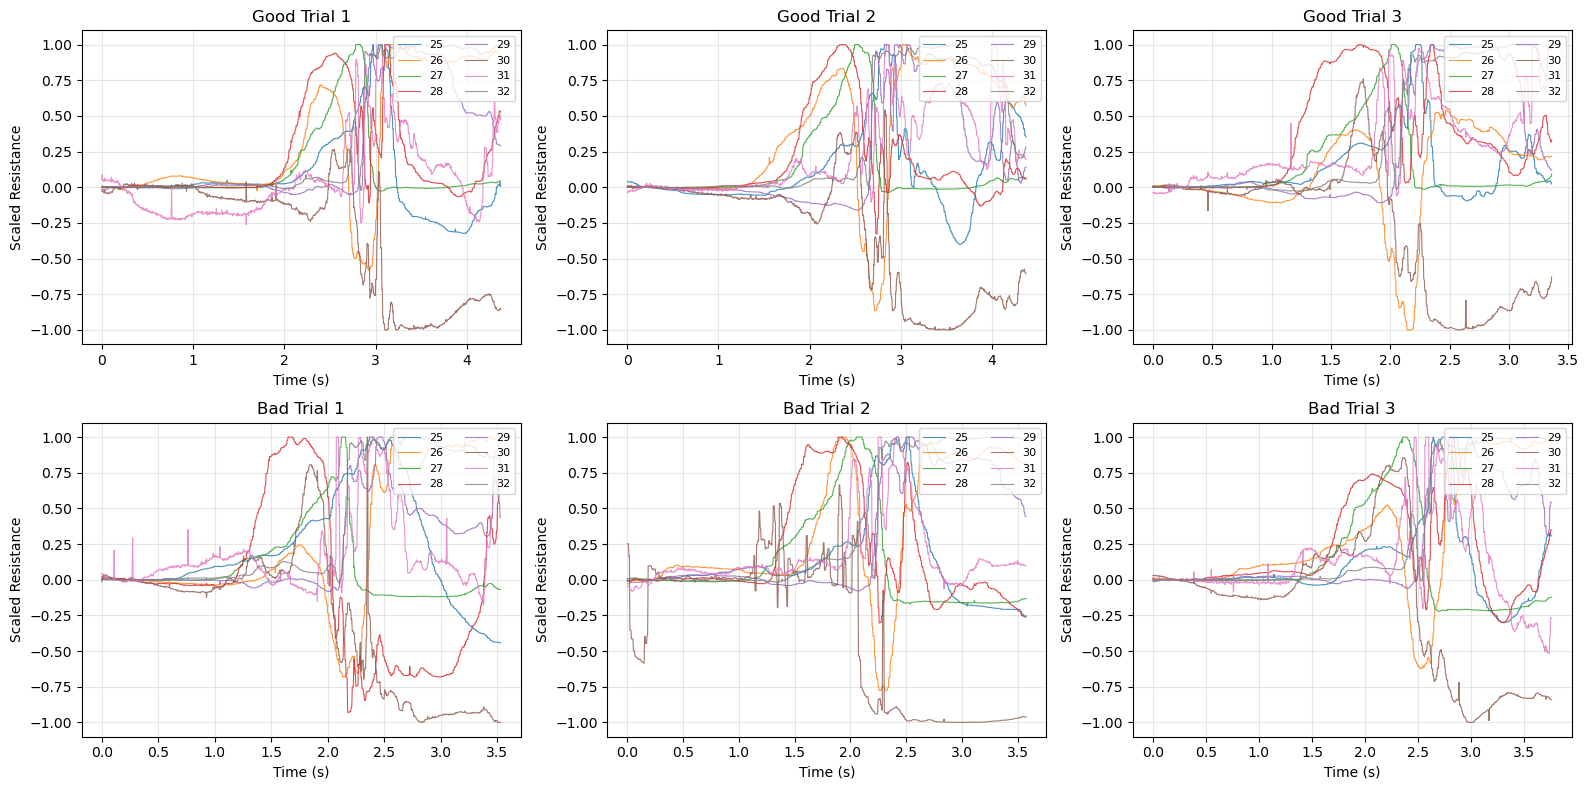

In [42]:
# Visualize sample good vs bad trials
def plot_trial(df, title="Trial", ax=None):
    """Plot all sensor channels for a single trial."""
    time = df["time"].values if "time" in df.columns else np.arange(len(df)) / 220.0
    sensor_cols = [c for c in df.columns if c != "time"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    for col in sensor_cols:
        ax.plot(time, df[col].values, label=col, alpha=0.8, linewidth=0.8)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Scaled Resistance")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1.1, 1.1)
    return ax

# Plot 3 good and 3 bad trials
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i in range(3):
    plot_trial(full_swing_good_ds[i], title=f"Good Trial {i+1}", ax=axes[0, i])
    plot_trial(full_swing_bad_ds[i], title=f"Bad Trial {i+1}", ax=axes[1, i])
plt.tight_layout()
plt.savefig("plots/good_vs_bad_trials.png", dpi=150)
plt.show()


In [43]:
# =============================================================================
# DATASET AND DATALOADER
# =============================================================================
class TimeSeriesDataset(Dataset):
    """Dataset for variable-length time series (DataFrames or arrays)."""
    def __init__(self, data, transform=None):
        self.items = []
        for item in data:
            if hasattr(item, "to_numpy"):  # pandas.DataFrame
                df = item.drop(columns=["time"]) if "time" in item.columns else item
                x = df.to_numpy(dtype=np.float32)
            else:
                x = np.asarray(item, dtype=np.float32)
                if x.ndim == 1:
                    x = x[:, None]
            self.items.append(torch.from_numpy(x))
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x = self.items[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, {"orig_len": x.shape[0]}


def pad_collate(batch):
    """Pad variable-length sequences to max length in batch."""
    xs, metas = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    C = xs[0].shape[1]
    T_max = max(lengths)
    
    x_pad = torch.zeros(len(xs), C, T_max, dtype=torch.float32)
    mask = torch.zeros(len(xs), 1, T_max, dtype=torch.float32)
    for i, x in enumerate(xs):
        T = x.shape[0]
        x_pad[i, :, :T] = x.T  # (T,C) -> (C,T)
        mask[i, :, :T] = 1.0
    return x_pad, mask, metas


In [44]:
# =============================================================================
# MODEL: 1D Convolutional Autoencoder
# =============================================================================
class CAE1D(nn.Module):
    """1D Convolutional Autoencoder with pooling downsampling and nearest-neighbor upsampling."""
    def __init__(self, in_channels: int, latent_dim: int = 128):
        super().__init__()
        
        def conv_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )
        
        def up_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, 32, k=7)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc2 = conv_block(32, 64, k=5)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc3 = conv_block(64, 128, k=5)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc4 = conv_block(128, latent_dim, k=3)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        # Decoder
        self.dec1 = up_block(latent_dim, 128, k=3)
        self.dec2 = up_block(128, 64, k=5)
        self.dec3 = up_block(64, 32, k=5)
        self.dec4 = up_block(32, in_channels, k=7)
        self.out_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def encoder(self, x):
        x = self.pool1(self.enc1(x))
        x = self.pool2(self.enc2(x))
        x = self.pool3(self.enc3(x))
        x = self.pool4(self.enc4(x))
        return x

    def decoder(self, z, target_T: int):
        x = self.dec1(z)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.out_conv(x)
        # Align length
        T = x.size(-1)
        if T > target_T:
            x = x[..., :target_T]
        elif T < target_T:
            x = F.pad(x, (0, target_T - T))
        return x

    def forward(self, x):
        T_target = x.size(-1)
        z = self.encoder(x)
        x_hat = self.decoder(z, target_T=T_target)
        return x_hat, z


In [45]:
# =============================================================================
# NORMALIZATION HELPERS
# =============================================================================
def fit_channel_stats(loader, max_batches=100):
    """Estimate per-channel mean/std from training data (ignores padding)."""
    s1, s2, N = None, None, None
    for i, (x, mask, _) in enumerate(loader):
        x = x.float()
        m = mask.expand(-1, x.shape[1], -1).float()
        s1_batch = (x * m).sum(dim=(0, 2))
        s2_batch = ((x ** 2) * m).sum(dim=(0, 2))
        N_batch = m.sum(dim=(0, 2))
        if s1 is None:
            s1, s2, N = s1_batch, s2_batch, N_batch
        else:
            s1 += s1_batch; s2 += s2_batch; N += N_batch
        if i + 1 >= max_batches:
            break
    mean = s1 / N
    std = ((s2 / N) - mean ** 2).clamp_min(1e-12).sqrt()
    return mean, std

def normalize_batch(x, mean, std):
    """Normalize batch: x (B,C,T), mean/std (C,)"""
    return (x - mean.view(1, -1, 1)) / std.view(1, -1, 1)

def denorm(xn, mean, std):
    """Denormalize back to original units."""
    return xn * std.view(1, -1, 1) + mean.view(1, -1, 1)


In [46]:
# =============================================================================
# TRAINING SETUP
# =============================================================================
BATCH_SIZE = 16
VAL_FRACTION = 0.2
EPOCHS = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets and loaders
dataset = TimeSeriesDataset(dfs, transform=None)
bad_set = TimeSeriesDataset(full_swing_bad_ds, transform=None)

val_len = int(len(dataset) * VAL_FRACTION)
train_len = len(dataset) - val_len
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(dataset, [train_len, val_len], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)
bad_loader = DataLoader(bad_set, batch_size=1, shuffle=False, collate_fn=pad_collate)

# Compute channel statistics from training data
ch_mean, ch_std = fit_channel_stats(train_loader)
ch_mean, ch_std = ch_mean.to(device), ch_std.to(device)
print("Per-channel mean:", ch_mean[:5].tolist())
print("Per-channel std:", ch_std[:5].tolist())


Per-channel mean: [0.16097205877304077, 0.2563355565071106, 0.12317829579114914, 0.17779994010925293, 0.2499525249004364]
Per-channel std: [0.30402180552482605, 0.4549495577812195, 0.309362530708313, 0.356240838766098, 0.388406902551651]


In [47]:
# =============================================================================
# TRAINING LOOP
# =============================================================================
# Initialize model
x_tmp, _, _ = next(iter(train_loader))
C = x_tmp.shape[1]
model = CAE1D(in_channels=C, latent_dim=128).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def masked_mse(x_hat, x, mask):
    """MSE loss that ignores padded timesteps."""
    mask = mask.to(x.dtype)
    denom = mask.sum(dim=(1, 2), keepdim=True).clamp_min(1.0)
    mse_per_elem = (x_hat - x) ** 2 * mask
    return (mse_per_elem.sum(dim=(1, 2), keepdim=True) / denom).mean()

def run_epoch(loader, train=True):
    model.train(train)
    losses = []
    with torch.set_grad_enabled(train):
        for x, mask, _ in loader:
            x, mask = x.to(device), mask.to(device)
            x = normalize_batch(x, ch_mean, ch_std)
            x_hat, _ = model(x)
            # Align lengths if needed
            if x_hat.size(-1) != x.size(-1):
                T = min(x_hat.size(-1), x.size(-1))
                x_hat, x, mask = x_hat[..., :T], x[..., :T], mask[..., :T]
            loss = masked_mse(x_hat, x, mask)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
    return float(np.mean(losses))

# Training
history = defaultdict(list)
for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    history["train_loss"].append(tr)
    history["val_loss"].append(va)
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")


Epoch 001 | train 8.934555 | val 7.306554
Epoch 050 | train 3.243846 | val 3.476052
Epoch 100 | train 1.854842 | val 2.310639
Epoch 150 | train 1.135256 | val 1.596715
Epoch 200 | train 0.846657 | val 1.252935
Epoch 250 | train 0.518387 | val 1.049870
Epoch 300 | train 0.483472 | val 0.952460
Epoch 350 | train 0.353643 | val 0.868360
Epoch 400 | train 0.337731 | val 0.853773


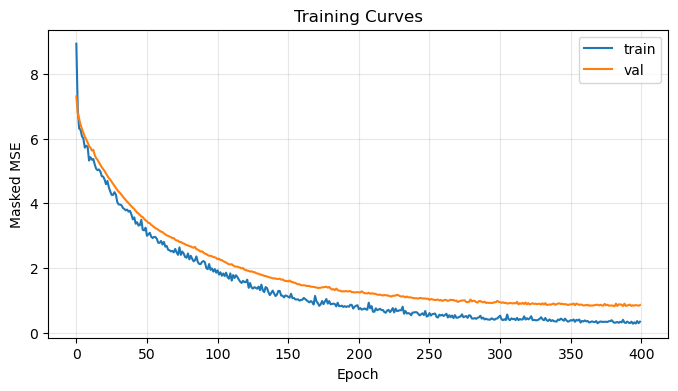

In [48]:
# =============================================================================
# TRAINING CURVES
# =============================================================================
plt.figure(figsize=(8, 4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Masked MSE")
plt.title("Training Curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("plots/training_curves.png", dpi=150)
plt.show()


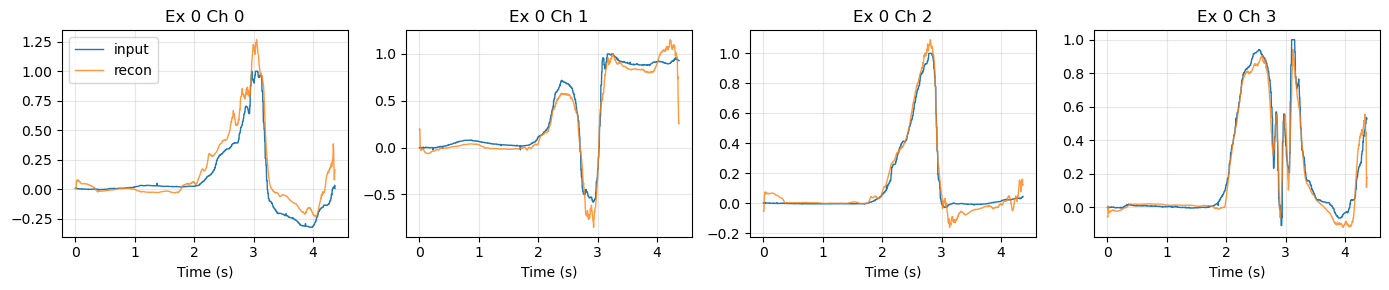

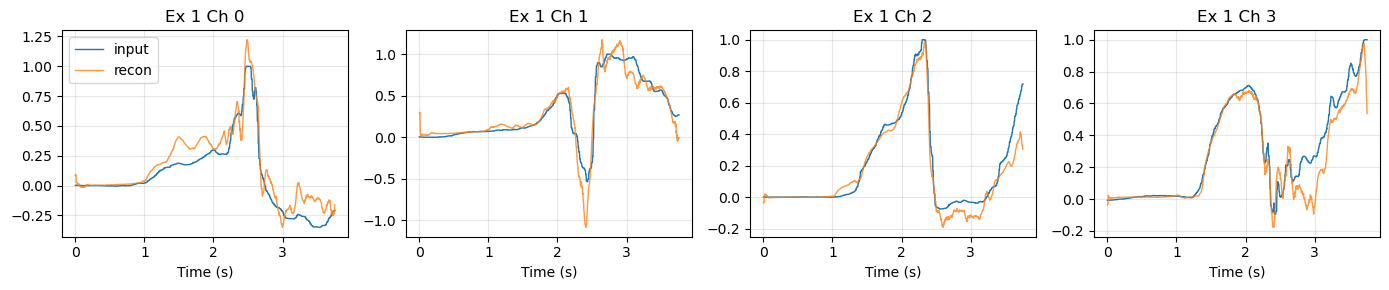

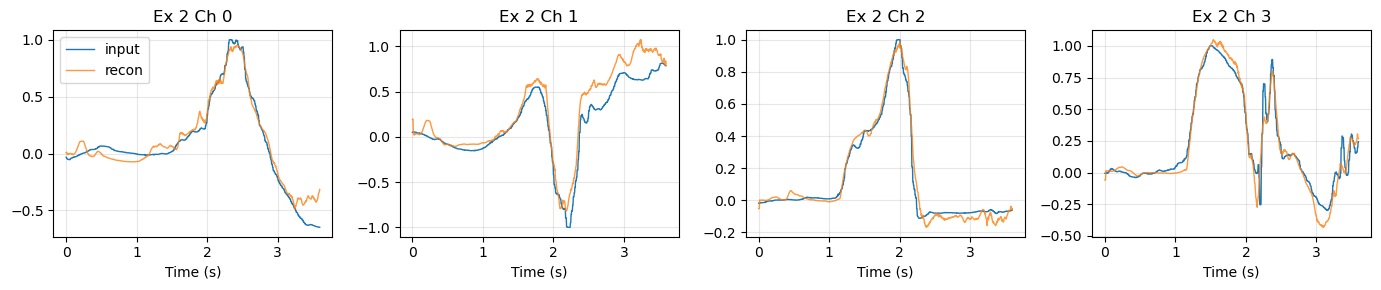

In [49]:
# =============================================================================
# RECONSTRUCTION EXAMPLES
# =============================================================================
@torch.no_grad()
def show_reconstruction(model, loader, ch_mean, ch_std, device, n_examples=3, fs=220.0):
    """Visualize input vs reconstruction for a few examples."""
    model.eval()
    x, mask, _ = next(iter(loader))
    x = x.to(device).float()
    mask = mask.to(device)
    
    x_n = normalize_batch(x, ch_mean, ch_std)
    y_n, _ = model(x_n)
    y = denorm(y_n, ch_mean, ch_std)
    
    T = min(x.size(-1), y.size(-1), mask.size(-1))
    x, y, mask = x[..., :T], y[..., :T], mask[..., :T]
    
    for e in range(min(n_examples, x.size(0))):
        valid = mask[e, 0, :].bool()
        t = np.arange(valid.sum().item()) / fs
        
        fig, axes = plt.subplots(1, 4, figsize=(14, 3))
        for j in range(4):
            xe = x[e, j, valid].cpu().numpy()
            ye = y[e, j, valid].cpu().numpy()
            axes[j].plot(t, xe, label="input", linewidth=1)
            axes[j].plot(t, ye, label="recon", linewidth=1, alpha=0.8)
            axes[j].set_title(f"Ex {e} Ch {j}")
            axes[j].set_xlabel("Time (s)")
            axes[j].grid(True, alpha=0.3)
        axes[0].legend()
        plt.tight_layout()
        plt.show()

show_reconstruction(model, val_loader, ch_mean, ch_std, device)


In [50]:
# =============================================================================
# ANOMALY DETECTION - Score bad trials
# =============================================================================
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

@torch.no_grad()
def extract_trial_features(model, loader, ch_mean, ch_std, device):
    """Extract reconstruction error features per trial."""
    model.eval()
    feats = []
    for x, mask, _ in loader:
        x = x.to(device).float()
        mask = mask.to(device).float()
        x_n = normalize_batch(x, ch_mean, ch_std)
        x_hat_n, _ = model(x_n)
        
        T = min(x_hat_n.size(-1), x_n.size(-1))
        x_n, x_hat_n = x_n[..., :T], x_hat_n[..., :T]
        maskT = mask[..., :T].expand_as(x_n)
        
        err = (x_hat_n - x_n).pow(2) * maskT
        denom = maskT.sum(dim=2).clamp_min(1.0)
        per_c_mse = err.sum(dim=2) / denom
        
        global_mean = per_c_mse.mean(dim=1, keepdim=True)
        global_max = per_c_mse.max(dim=1, keepdim=True).values
        f = torch.cat([global_mean, global_max, per_c_mse], dim=1)
        feats.append(f.cpu().numpy())
    return np.vstack(feats)

# Extract features and fit LOF
X_train = extract_trial_features(model, train_loader, ch_mean, ch_std, device)
X_bad = extract_trial_features(model, bad_loader, ch_mean, ch_std, device)

lof_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lof", LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)),
])
lof_pipe.fit(X_train)

pred = lof_pipe.predict(X_bad)
outlier_idx = np.where(pred == -1)[0].tolist()
print(f"Detected {len(outlier_idx)} outliers out of {len(X_bad)} bad trials: {outlier_idx}")




Detected 3 outliers out of 3 bad trials: [0, 1, 2]
